# A) Charger le sample clean

### utilisation de google colab et du GPU pour accélérer les executions
### si pas de GPU , passez au CPU

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from pathlib import Path

DATA_PATH = Path("/content/drive/Othercomputers/Mon ordinateur portable/Bureau/Audit_Report/data/complaints_sample.parquet")
df = pd.read_parquet(DATA_PATH)



In [3]:
# colonnes minimales
keep = ["narrative","product_5","Product","Issue","sub_issue","Company","State","date_received","timely_response","n_words"]
keep = [c for c in keep if c in df.columns]
df = df[keep].copy()



In [4]:
# doc_id stable
df = df.reset_index(drop=True)
df["doc_id"] = np.arange(len(df), dtype=np.int64)

print(df.shape)
df.head(2)

(25000, 10)


,narrative,Product,Issue,sub_issue,Company,State,date_received,timely_response,n_words,doc_id
0,On XX/XX/2020 I started receiving phone calls ...,Checking or savings account,Managing an account,Deposits and withdrawals,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,2021-01-12,Yes,289,0
1,I left the XXXX on XX/XX/XXXX after given two ...,Checking or savings account,Managing an account,Deposits and withdrawals,UNITED SERVICES AUTOMOBILE ASSOCIATION,TN,2023-03-11,Yes,345,1


# B) Installer/charger le modèle Jina

In [16]:
from sentence_transformers import SentenceTransformer
import os

model = SentenceTransformer("jinaai/jina-embeddings-v2-base-en", device="cuda")
 #ce modèle offre une limite de tokens allant jus'quà 768 tokens

Loading weights:   0%|          | 0/126 [00:00<?, ?it/s]

BertModel LOAD REPORT from: jinaai/jina-embeddings-v2-base-en
Key                                              | Status     | 
-------------------------------------------------+------------+-
encoder.layer.{0...11}.mlp.wo.weight             | UNEXPECTED | 
encoder.layer.{0...11}.mlp.layernorm.bias        | UNEXPECTED | 
encoder.layer.{0...11}.mlp.layernorm.weight      | UNEXPECTED | 
encoder.layer.{0...11}.mlp.gated_layers.weight   | UNEXPECTED | 
encoder.layer.{0...11}.mlp.wo.bias               | UNEXPECTED | 
encoder.layer.{0...11}.output.dense.weight       | MISSING    | 
encoder.layer.{0...11}.output.LayerNorm.weight   | MISSING    | 
encoder.layer.{0...11}.output.dense.bias         | MISSING    | 
encoder.layer.{0...11}.intermediate.dense.bias   | MISSING    | 
encoder.layer.{0...11}.intermediate.dense.weight | MISSING    | 
encoder.layer.{0...11}.output.LayerNorm.bias     | MISSING    | 
embeddings.position_embeddings.weight            | MISSING    | 

Notes:
- UNEXPECTED	:can be

# C) Encoder en batch

In [9]:
from pathlib import Path
Path("embeddings").mkdir(exist_ok=True)

np.save("embeddings/jina_sample.npy", emb)

meta_cols = [c for c in df.columns if c != "narrative"] + ["narrative"]
df[meta_cols].to_parquet("embeddings/meta_sample.parquet", index=False)

print("Saved:",
      "embeddings/jina_sample.npy",
      "embeddings/meta_sample.parquet")

Saved: embeddings/jina_sample.npy embeddings/meta_sample.parquet


### Vérification de la distribution de mots pour s'aligner au modèle

In [11]:
n_words_stats = df['n_words'].describe()
print(n_words_stats)

count    25000.000000
mean       216.949960
std        251.550187
min          1.000000
25%         79.000000
50%        150.000000
75%        265.000000
max       5947.000000
Name: n_words, dtype: float64


## Visualisation



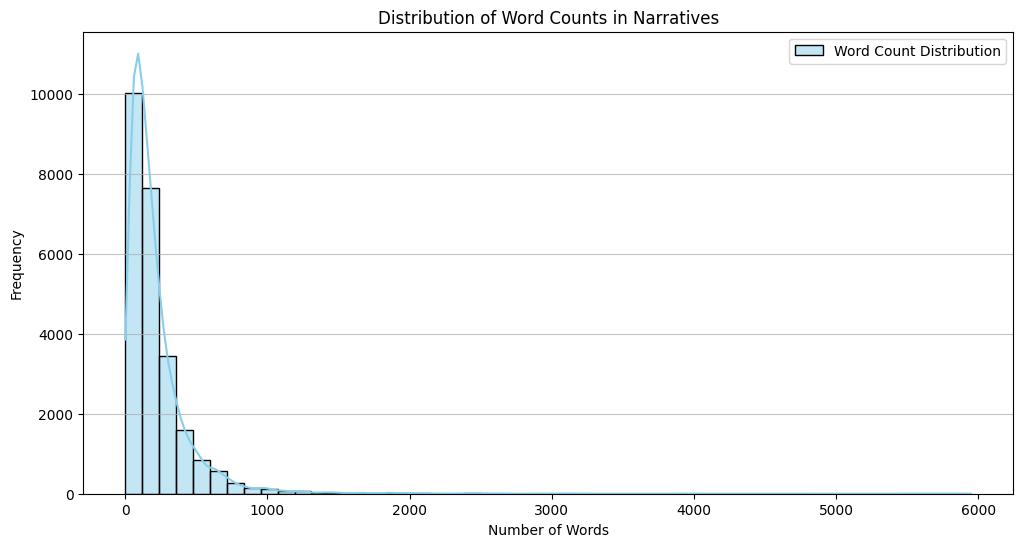

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df['n_words'], bins=50, kde=True, color='skyblue', label='Word Count Distribution')
plt.title('Distribution of Word Counts in Narratives')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

### le modèle a une limite de tokens de 768 , donc prendre une longueur max de 500 pour chaque "narrative" suffirait

In [13]:
# Filter out narratives with more than 500 words
df_filtered = df[df['n_words'] <= 500].copy()

print(f"Shape of original DataFrame: {df.shape}")
print(f"Shape of filtered DataFrame (n_words <= 500): {df_filtered.shape}")

display(df_filtered.head())

Shape of original DataFrame: (25000, 10)
Shape of filtered DataFrame (n_words <= 500): (22965, 10)


,narrative,Product,Issue,sub_issue,Company,State,date_received,timely_response,n_words,doc_id
0,On XX/XX/2020 I started receiving phone calls ...,Checking or savings account,Managing an account,Deposits and withdrawals,"BANK OF AMERICA, NATIONAL ASSOCIATION",CA,2021-01-12,Yes,289,0
1,I left the XXXX on XX/XX/XXXX after given two ...,Checking or savings account,Managing an account,Deposits and withdrawals,UNITED SERVICES AUTOMOBILE ASSOCIATION,TN,2023-03-11,Yes,345,1
3,My Credit Karma Spend account was fraudulently...,Checking or savings account,Managing an account,Problem using a debit or ATM card,"Credit Karma, LLC",TX,2024-05-08,Yes,237,3
4,I was charged two {$34.00} overdraft fees from...,Checking or savings account,Problem caused by your funds being low,Overdrafts and overdraft fees,JPMORGAN CHASE & CO.,CA,2018-12-13,Yes,383,4
5,On XX/XX/2020 someone named XXXX XXXX was able...,Checking or savings account,Problem with a lender or other company chargin...,Transaction was not authorized,Chime Financial Inc,AL,2020-12-09,Yes,58,5


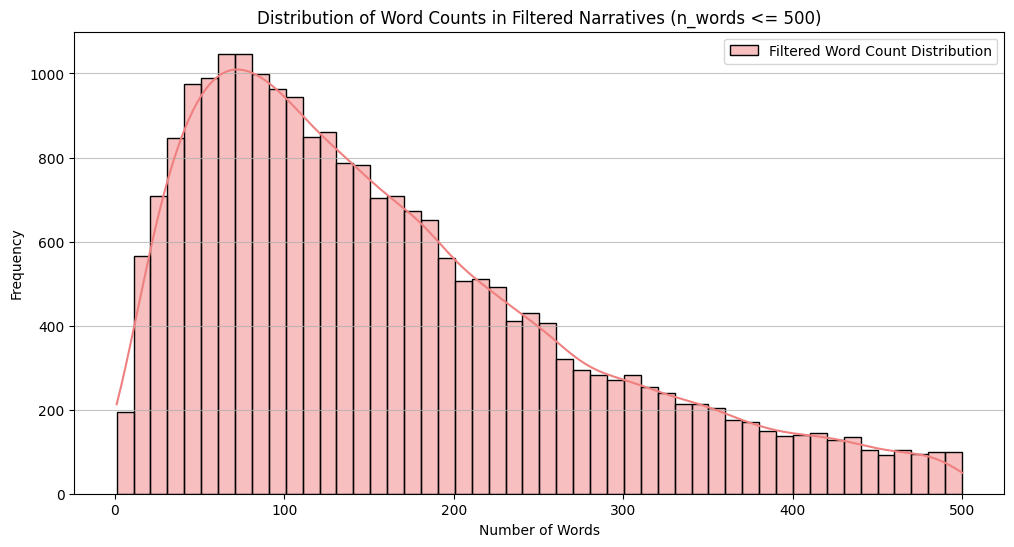

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 6))
sns.histplot(df_filtered['n_words'], bins=50, kde=True, color='lightcoral', label='Filtered Word Count Distribution')
plt.title('Distribution of Word Counts in Filtered Narratives (n_words <= 500)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.legend()
plt.grid(axis='y', alpha=0.75)
plt.show()

# C) Encoder en batch

In [17]:
texts_filtered = df_filtered["narrative"].astype(str).tolist()

# Re-start multi-process pool for embedding generation on GPU
pool_filtered = model.start_multi_process_pool(target_devices=["cuda"])

emb_filtered = model.encode_multi_process(
    texts_filtered,
    pool_filtered,
    batch_size=8,
    show_progress_bar=True,
    normalize_embeddings=True
)

model.stop_multi_process_pool(pool_filtered)
emb_filtered = np.asarray(emb_filtered, dtype=np.float32)
print(f"Shape of new embeddings (emb_filtered): {emb_filtered.shape}")

/tmp/ipython-input-77764284.py:6: DeprecationWarning: The `encode_multi_process` method has been deprecated, and its functionality has been integrated into `encode`. You can now call `encode` with the same parameters to achieve multi-process encoding.
  emb_filtered = model.encode_multi_process(


Chunks:   0%|          | 0/10 [00:00<?, ?it/s]

Shape of new embeddings (emb_filtered): (22965, 768)


# D) Sauvegarder embeddings + metadata

In [18]:
from pathlib import Path
Path("embeddings").mkdir(exist_ok=True)

# Save the new embeddings
np.save("embeddings/jina_sample_filtered.npy", emb_filtered)

# Save the metadata for the filtered DataFrame
meta_cols_filtered = [c for c in df_filtered.columns if c != "narrative"] + ["narrative"]
df_filtered[meta_cols_filtered].to_parquet("embeddings/meta_sample_filtered.parquet", index=False)

print("Saved:",
      "embeddings/jina_sample_filtered.npy",
      "embeddings/meta_sample_filtered.parquet")

Saved: embeddings/jina_sample_filtered.npy embeddings/meta_sample_filtered.parquet


# E) Test de recherche sémantique (sanity check)

In [21]:
import numpy as np

def cosine_topk(query, top_k=5):
    q = model.encode([query], normalize_embeddings=True).astype(np.float32)[0]
    scores = emb_filtered @ q  # cosine si emb et q normalisés
    idx = np.argsort(-scores)[:top_k]
    return df_filtered.loc[idx, ["Product","Issue","Company","n_words","narrative"]].assign(score=scores[idx])

cosine_topk("credit report inaccurate information", top_k=5)

,Product,Issue,Company,n_words,narrative,score
37,"Money transfer, virtual currency, or money ser...",Fraud or scam,"Coinbase, Inc.",53,COINBASE FACILITATED MONEY TRANSFER TO FAKE TR...,0.528512
10586,"Credit reporting, credit repair services, or o...",Incorrect information on your report,Experian Information Solutions Inc.,107,XXXXXXXX XXXX XXXX placed a item on my credit ...,0.501061
2968,Bank account or service,"Account opening, closing, or management",TD BANK US HOLDING COMPANY,61,"TD Bank reported me to XXXX on a "" erroneous c...",0.497001
21354,Consumer Loan,Taking out the loan or lease,"Byrider Franchising, LLC",75,My debit card was charge without authorization...,0.491226
1307,Checking or savings account,Managing an account,TRUIST FINANCIAL CORPORATION,278,Contacted Truist a couple weeks ago after I no...,0.490597
